In [ ]:
# ติดตั้งและนำเข้าไลบรารีที่จำเป็น
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.utils import resample
import pickle


# **เตรียมข้อมูล**

**Function สำหรับ cleaning ตัวข้อความ**

In [ ]:
# การทำความสะอาดข้อความ
def clean_text(text):
    # ลบสัญลักษณ์พิเศษและตัวเลข
    text = re.sub(r'[^A-Za-z\s\%\$\(\)]', '', text)

    # แปลงข้อความเป็นตัวพิมพ์เล็กทั้งหมด
    text = text.lower()

    # ลบตัวเลข
    text = re.sub(r'\d+', '', text)

    return text



In [ ]:
# อ่านไฟล์
Dataset_raw_FILE_LOCATION = "https://docs.google.com/uc?export=download&id=1WNvx2Toi8jTclKqnXfXE_HiWFCiLh6z_" #2_review_data.xlsx
colnames = ['label', 'message']
data = pd.read_excel(Dataset_raw_FILE_LOCATION, names=colnames, header=None)

print('------ info ------')
print(data.info())

print('\n------ shape ------')
print(data.shape)

print('\n------ label ------')
print(data['label'].value_counts())

------ info ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4846 non-null   object
 1   message  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None

------ shape ------
(4846, 2)

------ label ------
neutral     2879
positive    1363
negative     604
Name: label, dtype: int64


**ใช้ฟังก์ชั่นเพื่อทำความสะอาดข้อมูล**

**เช็คค่าว่าง เเละ ค่าซํ้า ก่อนเเละหลัง ทำความสะอาดข้อมูล**

In [ ]:
# เช็คจำนวน ค่าที่ว่าง เเละค่าซํ้า ก่อนทำความสำอาดข้อมูล
# หาค่าที่ว่างอยู่
print("เช็คจำนวน ค่าที่ว่าง เเละค่าซํ้า ก่อนทำความสำอาดข้อมูล \n")
missing_values = data.isnull().sum()
print("จำนวนค่าว่าง :\n",missing_values)
print("-----------------------------------------------")
#ตรวจสอบค่าที่ซํ้าหลังจาก clean_text
duplicate_count = data['message'].duplicated().sum()
print("จำนวนค่าที่ซ้ำในคอลัมน์ 'message':", duplicate_count)

เช็คจำนวน ค่าที่ว่าง เเละค่าซํ้า ก่อนทำความสำอาดข้อมูล 

จำนวนค่าว่าง :
 label      0
message    0
dtype: int64
-----------------------------------------------
จำนวนค่าที่ซ้ำในคอลัมน์ 'message': 8


In [ ]:
#ใช้ฟังก์ชั่น clean_text เพื่อทำความสะอาดข้อมูล
data['message'] = data['message'].apply(clean_text)

#ลบค่าซํ้าหลังจาก clean_text
data = data.drop_duplicates(subset=['message'], keep='first')
print(data.shape)

(4808, 2)


In [ ]:
# เช็คจำนวน ค่าที่ว่าง เเละค่าซํ้า หลังทำความสำอาดข้อมูล
# หาค่าที่ว่างอยู่
print("เช็คจำนวน ค่าที่ว่าง เเละค่าซํ้า หลังทำความสำอาดข้อมูล \n")
missing_values = data.isnull().sum()
print("จำนวนค่าว่าง :\n",missing_values)
print("-----------------------------------------------")
#ตรวจสอบค่าที่ซํ้าหลังจาก clean_text
duplicate_count = data['message'].duplicated().sum()
print("จำนวนค่าที่ซ้ำในคอลัมน์ 'message':", duplicate_count)

เช็คจำนวน ค่าที่ว่าง เเละค่าซํ้า หลังทำความสำอาดข้อมูล 

จำนวนค่าว่าง :
 label      0
message    0
dtype: int64
-----------------------------------------------
จำนวนค่าที่ซ้ำในคอลัมน์ 'message': 0


In [ ]:
# ตรวจสอบว่าเเต่ละ Class เหลืออยู่อยู่เท่าไร
data['label'].value_counts()

neutral     2861
positive    1348
negative     599
Name: label, dtype: int64

**เตรียมเเบ่งเเต่คลาสให้เท่า ๆ กัน**

In [ ]:
# ตั้งค่าจำนวนข้อมูลที่ต้องการในแต่ละคลาส
desired_sample_size_train = data['label'].value_counts().min()
print("min value : ",desired_sample_size_train)
# สร้าง DataFrame เปล่าสำหรับ train_data และ test_data
train_data = pd.DataFrame(columns=['label', 'message'])

# วนลูปตามคลาส
for label_class in data['label'].unique():
    # กรองข้อมูลในแต่ละคลาส
    class_data = data[data['label'] == label_class]

    # สุ่มข้อมูลเพื่อ train_data
    sampled_data_train = class_data.sample(n=desired_sample_size_train, random_state=160)

    # เพิ่มข้อมูลที่ถูกสุ่มไปยัง train_data
    train_data = pd.concat([train_data, sampled_data_train], ignore_index=True)

# แสดง train_data และ test_data
print("train_data:")
print(train_data)

# บันทึกเป็นไฟล์
train_data.to_csv('train_data.csv', index=False)


min value :  599
train_data:
         label                                            message
0      neutral  the group also plans to launch the  room atria...
1      neutral  the tower s engineers have created an  degree ...
2      neutral  the extraordinary general meeting is expected ...
3      neutral  the chilled meat products category led the mea...
4      neutral       the value of the contracts is about eur  mn 
...        ...                                                ...
1792  positive  it combines a perfect price performance with s...
1793  positive          demand for sports equipment was good in  
1794  positive  the finnish group anticipates a sales gain of ...
1795  positive   by separating side businesses we will be able...
1796  positive  the amending of the proposal simplifies the pr...

[1797 rows x 2 columns]


In [ ]:
# ตรวจสอบว่าเเต่ละ Class เหลืออยู่อยู่เท่าไรหลังจากการเเบ่ง
train_data['label'].value_counts()

neutral     599
negative    599
positive    599
Name: label, dtype: int64

In [ ]:
# หาค่าที่ว่างอยู่
missing_values = train_data.isnull().sum()
print("จำนวนค่าว่างในคอลัมน์ :\n",missing_values)
print("-----------------------------------------------")
#ตรวจสอบค่าที่ซํ้าหลังจาก clean_text
duplicate_count = train_data['message'].duplicated().sum()
print("จำนวนค่าที่ซ้ำในคอลัมน์ 'message':", duplicate_count)

จำนวนค่าว่างในคอลัมน์ :
 label      0
message    0
dtype: int64
-----------------------------------------------
จำนวนค่าที่ซ้ำในคอลัมน์ 'message': 0


**เตรียมจ้อมูลสำหรับ train เเละ test**

In [ ]:
# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
x = train_data['message']
le = LabelEncoder()
y = le.fit_transform(train_data["label"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=160)

# สร้าง TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)


# **Modeling การทำโมเดล**

# **SVM**

In [ ]:
# สร้างและฝึก SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(x_train_tfidf, y_train)


# ทดสอบและประเมินประสิทธิภาพของ model
y_pred_svm = svm_model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report SVM :\n", classification_report(y_test, y_pred_svm, target_names=le.classes_))

Accuracy: 67.78%
Classification Report SVM :
               precision    recall  f1-score   support

    negative       0.75      0.78      0.76       177
     neutral       0.59      0.68      0.63       164
    positive       0.70      0.58      0.64       199

    accuracy                           0.68       540
   macro avg       0.68      0.68      0.68       540
weighted avg       0.68      0.68      0.68       540



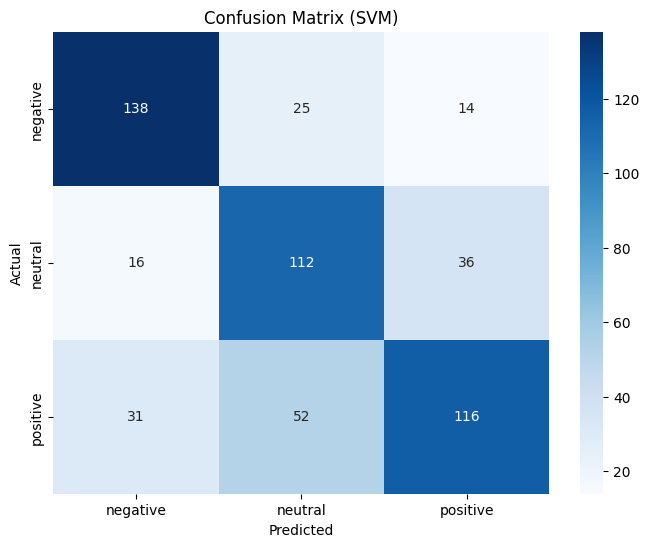

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# confusion_matrix
cm = confusion_matrix(y_test, y_pred_svm)

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()

In [ ]:
with open('svm_model2.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)
with open('vec_test.pkl', 'wb') as model_file:
    pickle.dump(tfidf_vectorizer, model_file)

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# สร้างและฝึก MultinomialNB model
modelNB = MultinomialNB()
modelNB.fit(x_train_tfidf, y_train)


# ทดสอบและประเมินประสิทธิภาพของ model
y_pred_nb = modelNB.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_nb)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report MultinomialNB :\n", classification_report(y_test, y_pred_nb, target_names=le.classes_))

Accuracy: 62.41%
Classification Report MultinomialNB :
               precision    recall  f1-score   support

    negative       0.61      0.84      0.70       177
     neutral       0.61      0.61      0.61       164
    positive       0.67      0.45      0.54       199

    accuracy                           0.62       540
   macro avg       0.63      0.63      0.62       540
weighted avg       0.63      0.62      0.61       540



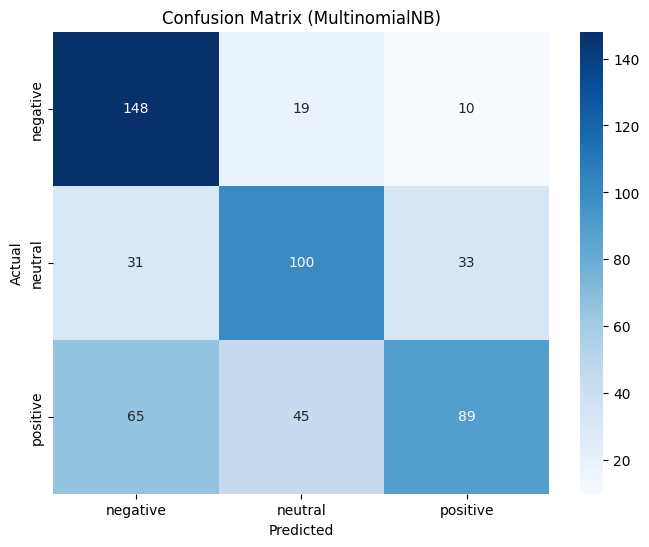

In [ ]:
# confusion_matrix
cm = confusion_matrix(y_test, y_pred_nb)

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (MultinomialNB)')
plt.show()

In [ ]:
with open('model_NB.pkl', 'wb') as model_file:
    pickle.dump(modelNB, model_file)
with open('vec_NB.pkl', 'wb') as model_file:
    pickle.dump(tfidf_vectorizer, model_file)

# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
# สร้างและฝึกโมเดล Logistic Regression
logreg_model = LogisticRegression()
logreg_model.fit(x_train_tfidf, y_train)

# ทำนายบนชุดทดสอบ
y_pred_logreg = logreg_model.predict(x_test_tfidf)

# ประเมินประสิทธิภาพ
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report LogisticRegression :\n", classification_report(y_test, y_pred_logreg, target_names=le.classes_))

Accuracy: 66.11%
Classification Report LogisticRegression :
               precision    recall  f1-score   support

    negative       0.74      0.71      0.72       177
     neutral       0.57      0.74      0.65       164
    positive       0.71      0.55      0.62       199

    accuracy                           0.66       540
   macro avg       0.67      0.67      0.66       540
weighted avg       0.67      0.66      0.66       540



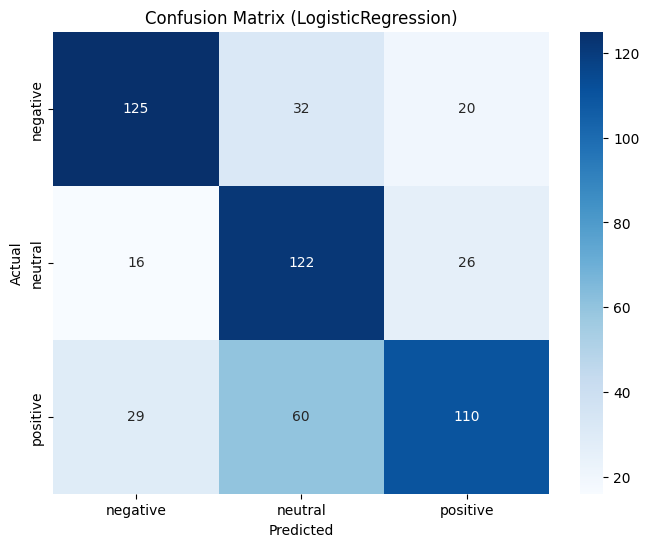

In [ ]:
# confusion_matrix
cm = confusion_matrix(y_test, y_pred_logreg)

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LogisticRegression)')
plt.show()

In [ ]:
with open('model_logistic.pkl', 'wb') as model_file:
    pickle.dump(modelNB, model_file)
with open('vec_logistic.pkl', 'wb') as model_file:
    pickle.dump(tfidf_vectorizer, model_file)

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# สร้างและฝึกโมเดล Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # ปรับตามความต้องการ
rf_model.fit(x_train_tfidf, y_train)

# ทดสอบโมเดลและประเมินประสิทธิภาพ
y_pred_rf = rf_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report Random Fores :\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))


Accuracy: 60.74%
Classification Report Random Fores :
               precision    recall  f1-score   support

    negative       0.70      0.67      0.69       177
     neutral       0.52      0.82      0.63       164
    positive       0.69      0.37      0.48       199

    accuracy                           0.61       540
   macro avg       0.63      0.62      0.60       540
weighted avg       0.64      0.61      0.59       540



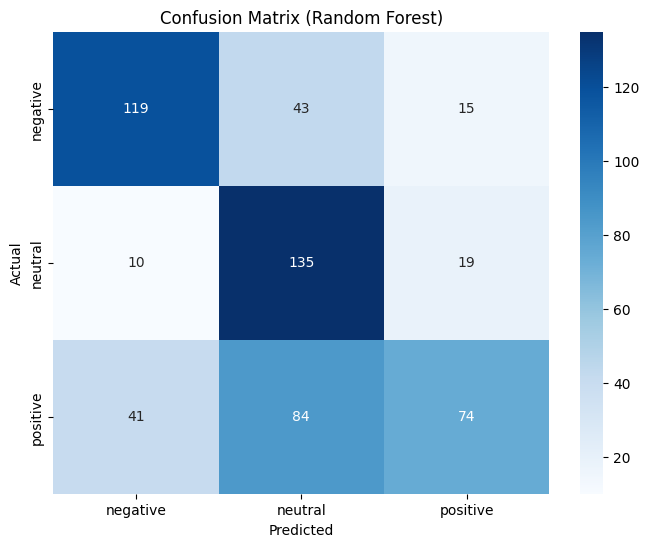

In [ ]:
# confusion_matrix
cm = confusion_matrix(y_test, y_pred_rf)

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# **DecisionTreeClassifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# สร้างและฝึกโมเดล Decision Trees
dt_model = DecisionTreeClassifier(random_state=160)  # ปรับตามความต้องการ
dt_model.fit(x_train_tfidf, y_train)

# ทดสอบโมเดลและประเมินประสิทธิภาพ
y_pred_dt = dt_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report DecisionTreeClassifier :\n", classification_report(y_test, y_pred_dt, target_names=le.classes_))



Accuracy: 56.11%
Classification Report DecisionTreeClassifier :
               precision    recall  f1-score   support

    negative       0.64      0.62      0.63       177
     neutral       0.49      0.60      0.54       164
    positive       0.56      0.48      0.52       199

    accuracy                           0.56       540
   macro avg       0.57      0.57      0.56       540
weighted avg       0.57      0.56      0.56       540



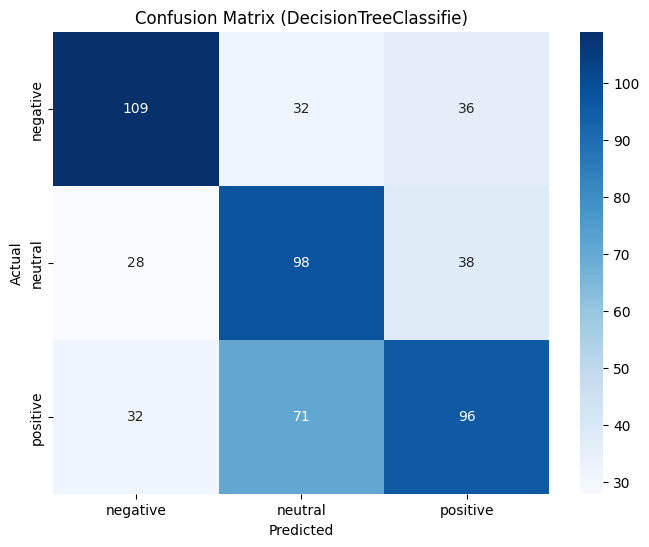

In [ ]:
# confusion_matrix
cm = confusion_matrix(y_test, y_pred_dt)

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (DecisionTreeClassifie)')
plt.show()

# **Deep learning Bi-LSTM**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Flatten, Bidirectional, LSTM
from tensorflow.keras.models import Sequential

train_data['message']
# 2. แบ่งข้อมูลเป็นแรนดอมและเน็กาทีฟ
X = train_data['message']  # คอลัมน์ที่มีข้อความ
y = train_data['label']  # คอลัมน์ที่มี label

# 3. แปลง label เป็นรูปแบบ One-Hot Encoding
y = pd.get_dummies(y)

# 4. แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=160)

# 5. กำหนดพารามิเตอร์สำหรับการโทเคนไปร์ข้อความ
max_words = 10000  # จำนวนคำที่จะใช้ในพจนานุกรม
max_len = 100  # จำนวนคำสูงสุดในข้อความที่จะใช้ในโมเดล

# 6. ใช้ Tokenizer เพื่อทำการแปลงข้อความเป็นตัวเลข
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 7. ทำการ Zero-padding เพื่อให้ข้อมูลมีความยาวเท่ากัน
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1

# 8. สร้างโมเดล Neural Network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(3, activation='softmax'))

# 9. คอมไพล์และฝึกโมเดล
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.3)

# 10. ทดสอบโมเดล
accuracy = model.evaluate(X_test_pad, y_test)
print("Test Accuracy: ", accuracy[1])




Epoch 1/10
14/14 [==============================] - 8s 230ms/step - loss: 1.0931 - accuracy: 0.4141 - val_loss: 1.0863 - val_accuracy: 0.4577
Epoch 2/10
14/14 [==============================] - 2s 129ms/step - loss: 1.0494 - accuracy: 0.5688 - val_loss: 1.0542 - val_accuracy: 0.4788
Epoch 3/10
14/14 [==============================] - 2s 129ms/step - loss: 0.9485 - accuracy: 0.5882 - val_loss: 0.9941 - val_accuracy: 0.5106
Epoch 4/10
14/14 [==============================] - 3s 199ms/step - loss: 0.8056 - accuracy: 0.6405 - val_loss: 0.9454 - val_accuracy: 0.5344
Epoch 5/10
14/14 [==============================] - 3s 188ms/step - loss: 0.6826 - accuracy: 0.7554 - val_loss: 0.8870 - val_accuracy: 0.5847
Epoch 6/10
14/14 [==============================] - 2s 118ms/step - loss: 0.5390 - accuracy: 0.8840 - val_loss: 0.8345 - val_accuracy: 0.6243
Epoch 7/10
14/14 [==============================] - 2s 119ms/step - loss: 0.3960 - accuracy: 0.9488 - val_loss: 0.8193 - val_accuracy: 0.6190
Epoch 

17/17 [==============================] - 1s 31ms/step


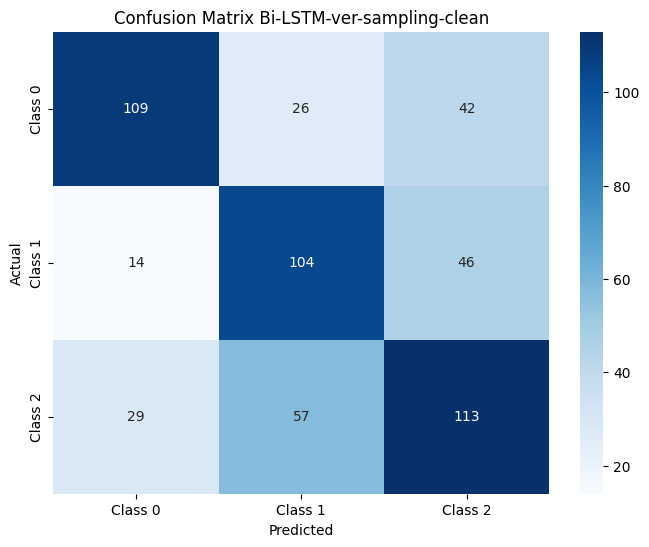

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# โค้ดเดิมจากข้อความก่อนหน้า

# 10. ทดสอบโมเดล
y_pred = model.predict(X_test_pad)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(np.array(y_test), axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred)

# บันทึก Confusion Matrix ในไฟล์
class_names = ['Class 0', 'Class 1', 'Class 2']
df_cm = pd.DataFrame(confusion_mtx, index=class_names, columns=class_names)
# df_cm = pd.DataFrame(confusion_mtx, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Bi-LSTM-ver-sampling-clean')
plt.savefig('confusion_matrix-Bi-LSTM-ver-clean-samp.png')  # บันทึกเป็นไฟล์รูปภาพ
plt.show()

In [ ]:
# 11. ทำนายคลาสที่ได้จากโมเดล
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# 12. แปลง One-Hot Encoding กลับเป็นรูปแบบเดิม
y_test_original = np.argmax(np.array(y_test), axis=1)

# 13. สร้าง Classification Report
report = classification_report(y_test_original, y_pred)

# 14. แสดงผล Classification Report
print(report)


17/17 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.72      0.62      0.66       177
           1       0.56      0.63      0.59       164
           2       0.56      0.57      0.57       199

    accuracy                           0.60       540
   macro avg       0.61      0.61      0.61       540
weighted avg       0.61      0.60      0.61       540

